# Goal of the project
The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

# Load Data

In [1]:
import glob

car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

print("The number of car images is " + str(len(car_images))) 
print("The number of noncar images is " + str(len(noncar_images)))

The number of car images is 8792
The number of noncar images is 8968


# Visualize the images

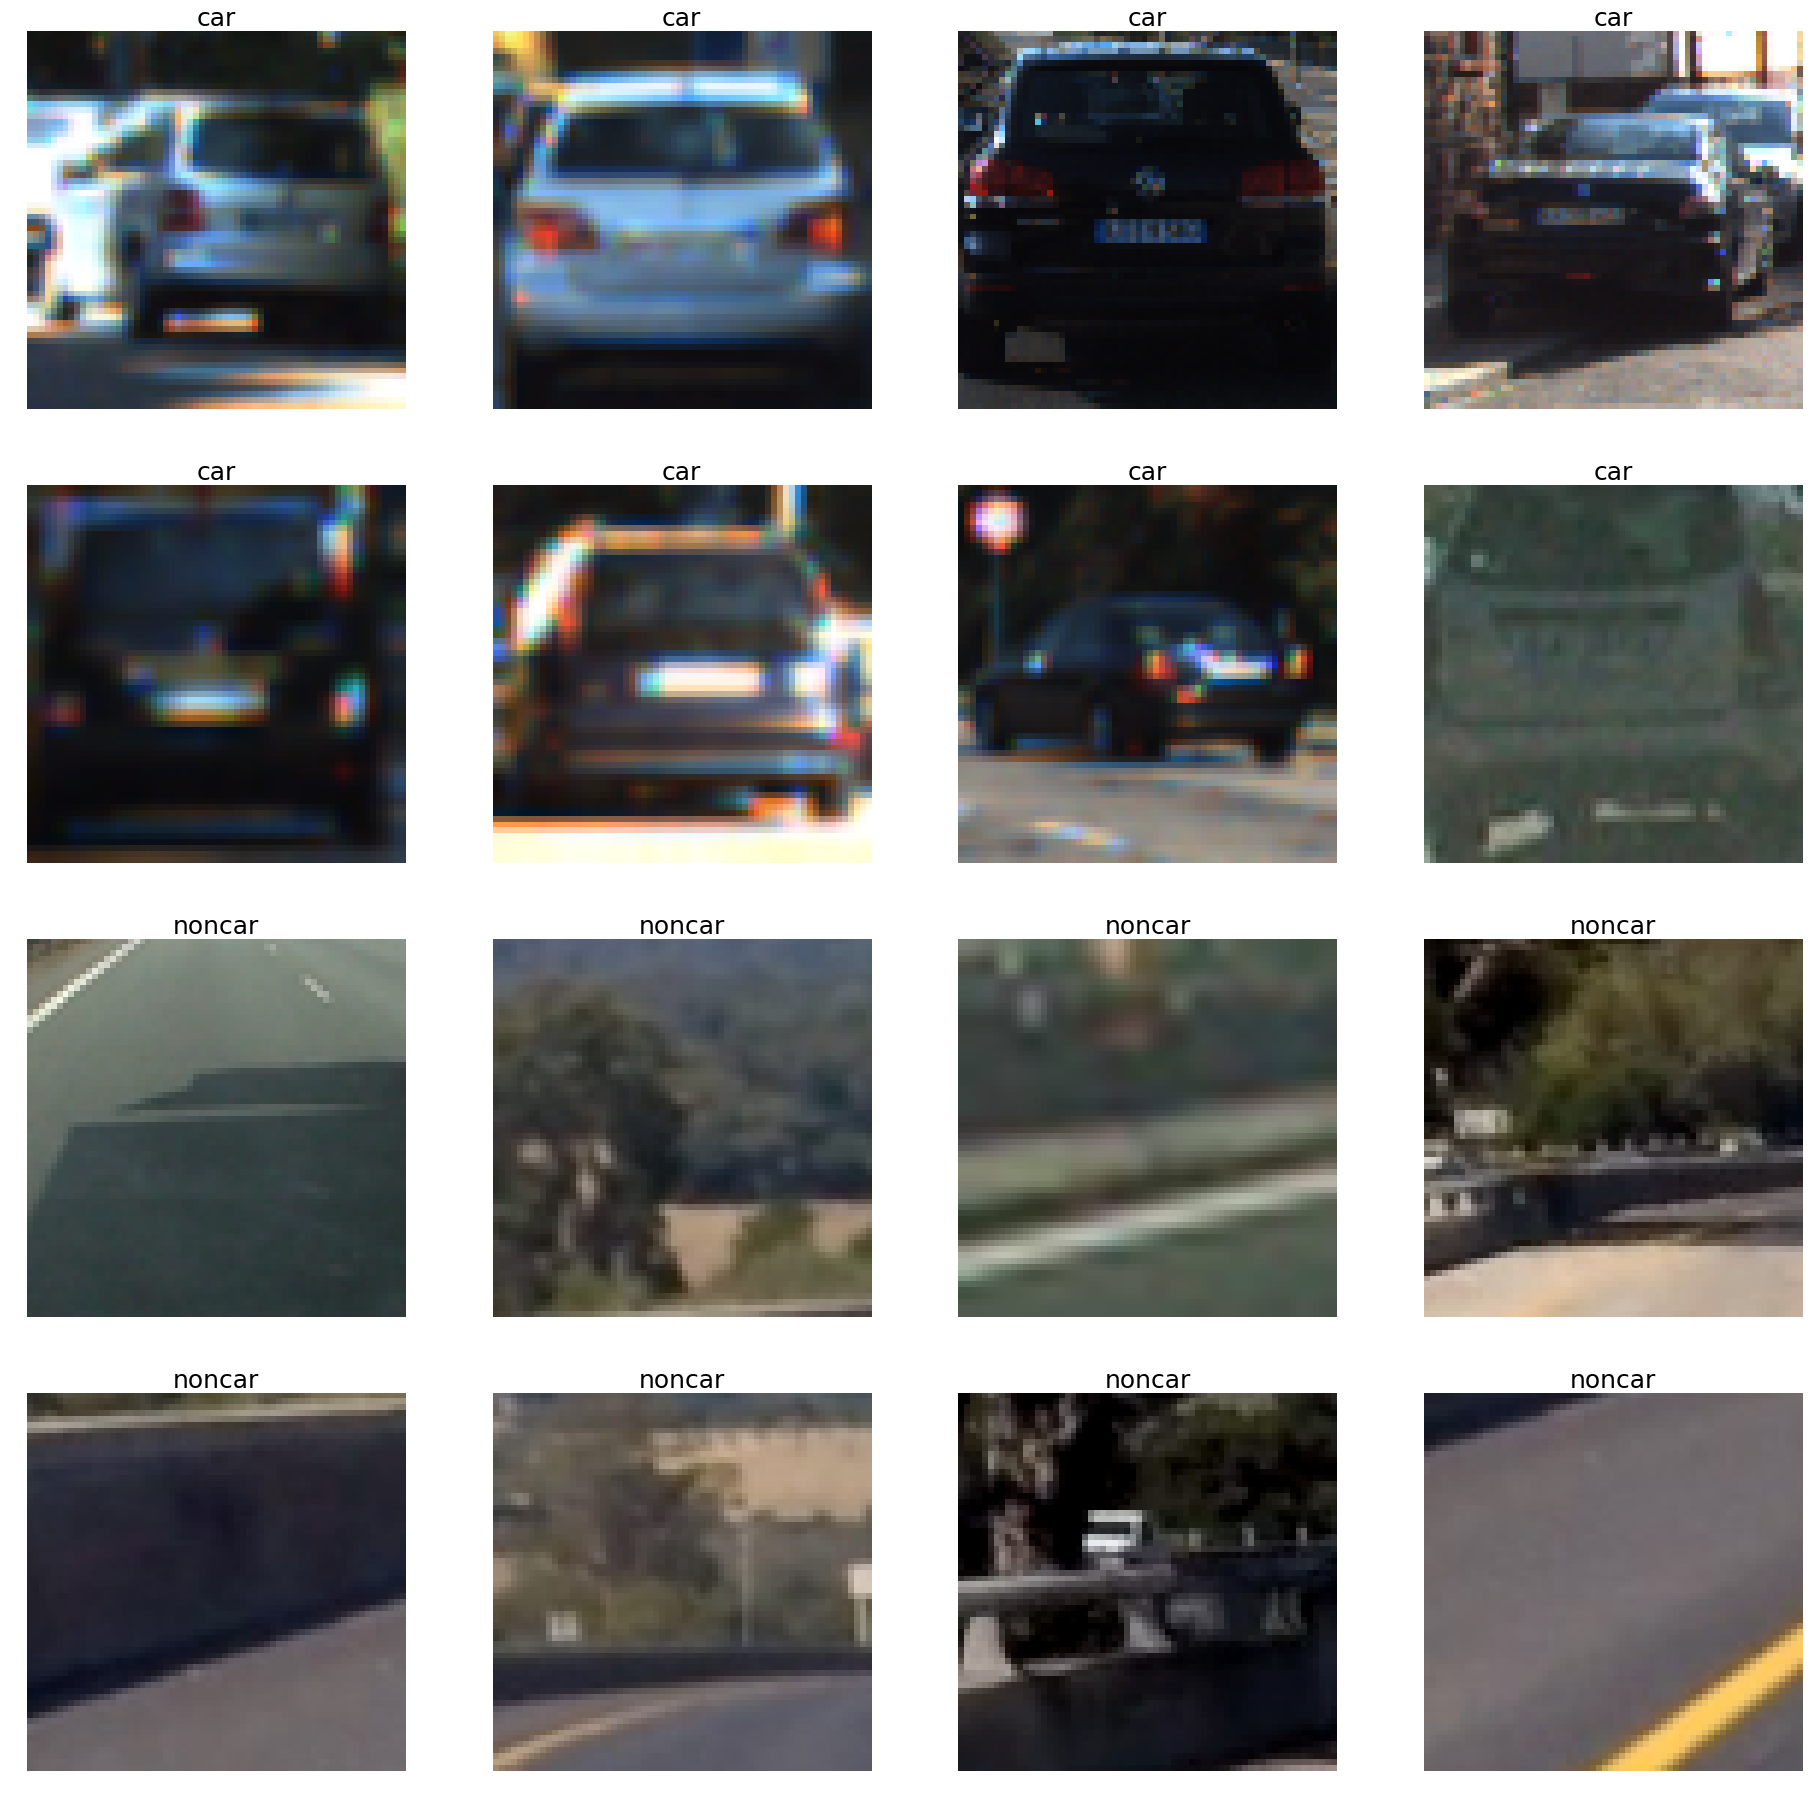

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

figure, axs = plt.subplots(4, 4, figsize=(32,32))
axs = axs.ravel()

for i in np.arange(8):
    image = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize = 25)
    axs[i].imshow(image)

for i in np.arange(8, 16):
    image = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('noncar', fontsize = 25)
    axs[i].imshow(image) 

# Extract Color-based Features
Note that the color below comes from the course materials.

In [23]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_color(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Histogram of Oriented Gradients (HOG) Feature Extraction

Note: The following code comes from the lesson materials.

In [5]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Visualize the HOG feature on some images.

/Users/damao/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


...


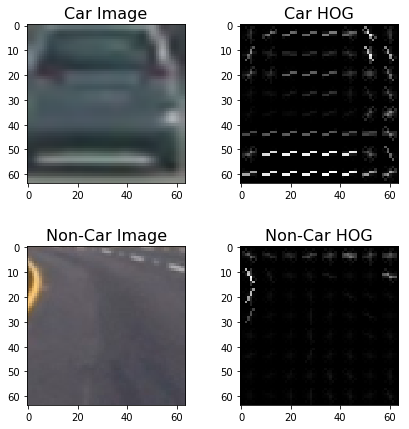

In [6]:
car_img = mpimg.imread(car_images[8])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[8])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

## Extract HOG Features from a List of Images
Note: the code below (mostly) comes from the lesson materials.

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Extract features and prepare the data

In [58]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature extraction parameters
colorspace_hog = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features_hog = extract_features_hog(car_images, cspace=colorspace_hog, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
noncar_features_hog = extract_features_hog(noncar_images, cspace=colorspace_hog, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# colorspace_color='RGB'
# spatial_size=(32, 32)
# hist_bins=32
# hist_range=(0, 256)

# car_features_color = extract_features_color(car_images, cspace=colorspace_color, spatial_size=spatial_size,
#                         hist_bins=hist_bins, hist_range=hist_range)

# noncar_features_color = extract_features_color(noncar_images, cspace=colorspace_color, spatial_size=spatial_size,
#                         hist_bins=hist_bins, hist_range=hist_range)

# X_cars = np.hstack((car_features_hog, car_features_color))
# X_noncars = np.hstack((noncar_features_hog, noncar_features_color))

X_cars = car_features_hog
X_noncars = noncar_features_hog

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((X_cars, X_noncars)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features_hog)), np.zeros(len(noncar_features_hog))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# # Fit a per-column scaler. 
# X_scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X_train and X_test
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

/Users/damao/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


49.33 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [59]:
# Some test on stacking the data
# a = np.array([[11,22],[33,44]])
# b = np.array([[55,66],[77,88]])
# print((a.shape, b.shape))
# t = np.vstack((a, b)).astype(np.float64)
# print(t)
# t2 = np.hstack((a, b))
# print(t2)

### Train a Classifier

In [60]:
from sklearn.svm import LinearSVC
import time

# Use a linear SVC
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2=time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.00167 Seconds to predict 10 labels with SVC


### Use classifier to detect cars in an image
The following code comes from the lesson materials but the spatial binning and scaling are commented out.

In [61]:
def convert_color2(image, cspace='YUV'):
    feature_image = np.copy(image)
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return feature_image

In [62]:
# def convert_color(img, conv='RGB2YCrCb'):
#     if conv == 'RGB2YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     if conv == 'BGR2YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#     if conv == 'RGB2LUV':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              colorspace_hog, orient, pix_per_cell, cell_per_block, 
              colorspace_color, spatial_size, hist_bins, hist_range):
    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = convert_color2(img_tosearch, cspace=colorspace_hog)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
#             subimg = convert_color2(subimg, cspace=colorspace_color)
            # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
#             test_prediction = svc.predict(test_features)
            test_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, rectangles

/Users/damao/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes drawn:  4


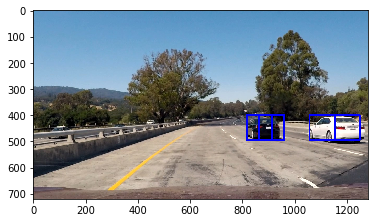

In [63]:
# Now let's test it on an example image
test_image = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace_hog = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

colorspace_color='RGB'
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)

out_img, rectangles = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, 
                                colorspace_hog, orient, pix_per_cell, cell_per_block, 
                                colorspace_color, spatial_size, hist_bins, hist_range)

plt.imshow(out_img)
print("Number of boxes drawn: ", len(rectangles))

### Search by different window size/scale
The size of a car in the image is relative to the distance from the camera. That is, the closer it is to the camer, the large it appears in the image. Therefore, we may need to call the `find_cars` method a few times with different parameters to find all possible matching rectangle areas.

In [64]:
def draw_boxes(img, boxes):
    draw_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(draw_img, box[0], box[1] ,(0,0,255), 6)
    return draw_img

/Users/damao/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


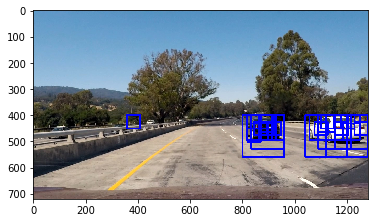

In [65]:
colorspace_hog = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

scales = [0.8, 1.0, 1.5, 2, 2.5, 3, 3,5]
rects = []

test_image = mpimg.imread('./test_images/test1.jpg')

for scale in scales:
    _, rectangles = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, 
                                colorspace_hog, orient, pix_per_cell, cell_per_block, 
                                colorspace_color, spatial_size, hist_bins, hist_range)
    rects.append(rectangles)
    
rectangles = [item for sublist in rects for item in sublist] 

test_image_drawn = draw_boxes(test_image, rectangles)
plt.imshow(test_image_drawn)


### Remove False Positives by using HeatMap
There may be false positives in the detection which we can identify by using Heatmap of the detection area overlaps and remove by applying a threshold on the heat level. The methods below comes from the lesson material.

In [66]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

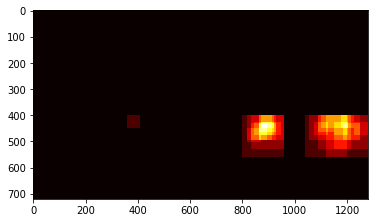

In [67]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

heatmap = add_heat(heat, rectangles)
plt.imshow(heatmap, cmap='hot')

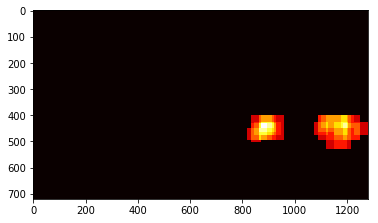

In [72]:
# now apply a threshold
heatmap = apply_threshold(heatmap, 2)
plt.imshow(heatmap, cmap='hot')

### Get the labels from the heatmap

2 cars found


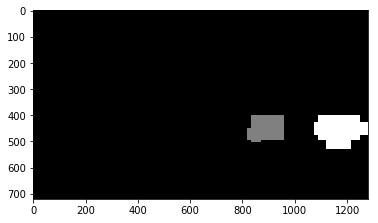

In [73]:
from scipy.ndimage.measurements import label
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

### Draw the label bounding boxes back on the image

In [74]:
def draw_labeled_bboxes(img, labels):
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_img

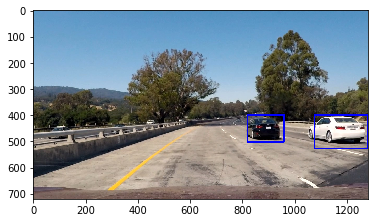

In [75]:
draw_img = draw_labeled_bboxes(test_image, labels)
plt.imshow(draw_img)

### Tracking Pipeline

In [76]:
def process_frame(image):
    colorspace_hog = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    scales = [0.8, 1.0, 1.5, 2, 2.5, 3, 3.5]
    rects = []

    for scale in scales:
        _, rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                                colorspace_hog, orient, pix_per_cell, cell_per_block, 
                                colorspace_color, spatial_size, hist_bins, hist_range)
        rects.append(rectangles)

    rectangles = [item for sublist in rects for item in sublist] 

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, rectangles)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    
    return draw_img

/Users/damao/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


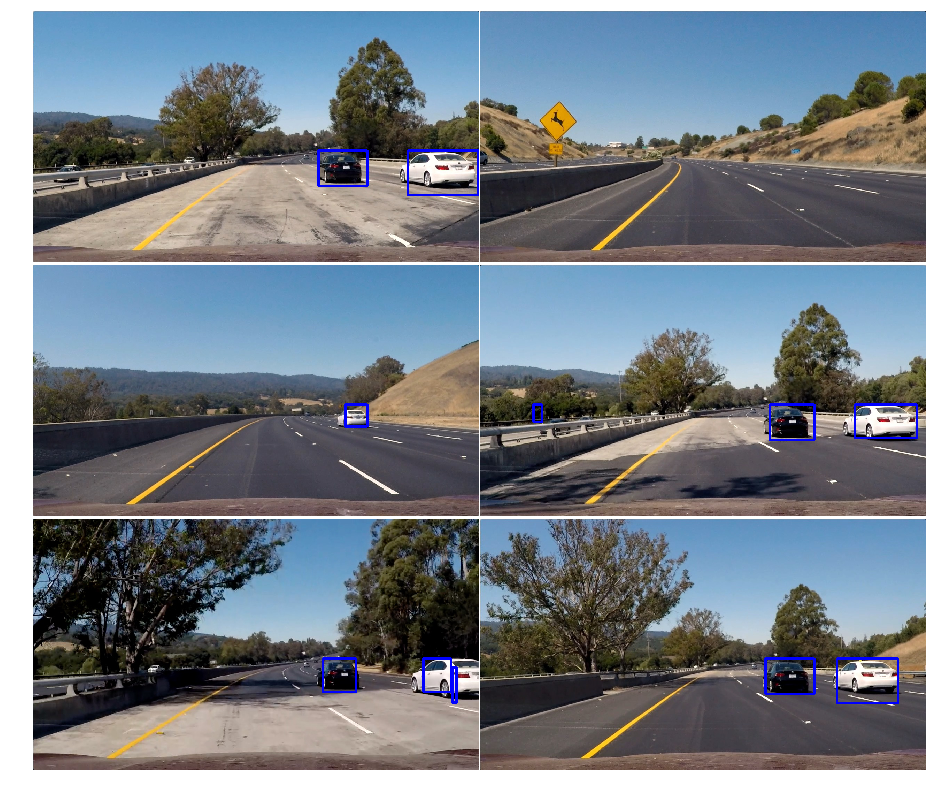

In [77]:
# Run the pipeline through all test images.
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, image_path in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(image_path)))
    axs[i].axis('off')

### Run the pipeline on a video stream

In [78]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:24<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 22.4 s, sys: 2.84 s, total: 25.2 s
Wall time: 24.8 s


In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

### Analysis
It seems that the bounding boxes are rather unstable and there are small and noisy boxes drawn on the lane where no cars should be detected. We can try tracking the rectangles in previous frames and see if that averages those noise out.

### Define a Class to Store Data from Vehicle Detections

In [80]:
# Define a class to store rectangles from video
class Rectangle_Detected():
    def __init__(self):
        # history of rectangles previous n frames
        self.previous_rectangles = [] 
        
    def add_rects(self, rects):
        self.previous_rectangles.append(rects)
        if len(self.previous_rectangles) > 10:
            # throw out oldest rectangle set(s)
            self.previous_rectangles = self.previous_rectangles[len(self.previous_rectangles)-10:]

In [81]:
def process_frame_tracking_previous_frame(image):
    colorspace_hog = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    scales = [0.8, 1.0, 1.5, 2, 2.5, 3, 3.5]
    rects = []

    for scale in scales:
        _, rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                                colorspace_hog, orient, pix_per_cell, cell_per_block, 
                                colorspace_color, spatial_size, hist_bins, hist_range)
        rects.append(rectangles)
    
    if len(rects) > 0:
        detected.add_rects([item for sublist in rects for item in sublist])
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    for rectangles in detected.previous_rectangles:
        heatmap = add_heat(heatmap, rectangles)
        
    heatmap = apply_threshold(heatmap, 1 + len(detected.previous_rectangles)//2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    
    return draw_img

In [82]:
detected = Rectangle_Detected()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_tracking_previous_frame)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 22.1 s, sys: 2.78 s, total: 24.8 s
Wall time: 24.4 s


In [83]:
detected = Rectangle_Detected()

project_video_out_file = 'project_video_out.mp4'
clip_test3 = VideoFileClip('project_video.mp4')
clip_test_out3 = clip_test3.fl_image(process_frame_tracking_previous_frame)
%time clip_test_out3.write_videofile(project_video_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [13:11<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 12min 13s, sys: 1min 32s, total: 13min 46s
Wall time: 13min 11s
